In [3]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import pandas as pd
import numpy as np
from JanetLSTM import JANET

Using TensorFlow backend.


In [4]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = [], []
    #i: n_in, n_in-1, ..., 1，为滞后期数
    #分别代表t-n_in, ... ,t-1期
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    #i: 0, 1, ..., n_out-1，为超前预测的期数
    #分别代表t，t+1， ... ,t+n_out-1期
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [6]:
def prepare_data(filepath, n_in, n_out=30, n_vars=4, train_proportion=0.8):
    #读取数据集
    dataset = read_csv(filepath, encoding='utf-8')
    dataset.drop("job_id", axis=1, inplace=True)
    dataset.drop("task_id", axis=1, inplace=True)
    #设置时间戳索引
#     dataset['日期'] = pd.to_datetime(dataset['日期'])
#     dataset.set_index("日期", inplace=True)
    values = dataset.values
    #保证所有数据都是float32类型
    values = values.astype('float32')
    #变量归一化
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    #将时间序列问题转化为监督学习问题
    reframed = series_to_supervised(scaled, n_in, n_out)
    #取出保留的变量
    contain_vars = []
    for i in range(1, n_in+1):
        contain_vars += [('var%d(t-%d)' % (j, i)) for j in range(1,n_vars+1)]  
    data = reframed [ contain_vars + ['var1(t)'] + [('var1(t+%d)' % (j)) for j in range(1,n_out)]]
    #修改列名
    col_names = ['Y', 'X1', 'X2', 'X3', 'X4', 'X5']
    contain_vars = []
    for i in range(n_vars):
        contain_vars += [('%s(t-%d)' % (col_names[i], j)) for j in range(1,n_in+1)]  
    data.columns = contain_vars +  ['Y(t)'] + [('Y(t+%d)' % (j)) for j in range(1,n_out)]
    #分隔数据集，分为训练集和测试集
    values = data.values
    n_train = round(data.shape[0]*train_proportion)
    train = values[:n_train, :]
    test = values[n_train:, :]
    #分隔输入X和输出y
    train_X, train_y = train[:, :n_in*n_vars], train[:, n_in*n_vars:]
    test_X, test_y = test[:, :n_in*n_vars], test[:, n_in*n_vars:]
    #将输入X改造为LSTM的输入格式，即[samples,timesteps,features]
    train_X = train_X.reshape((train_X.shape[0], n_in, n_vars))
    test_X = test_X.reshape((test_X.shape[0], n_in, n_vars))
    return scaler, data, train_X, train_y, test_X, test_y, dataset

In [7]:
def fit_lstm(data_prepare, n_neurons=50, n_batch=72, n_epoch=100, loss='mae', optimizer='adam', repeats=1):
    train_X = data_prepare[2]
    train_y = data_prepare[3]
    test_X = data_prepare[4]
    test_y = data_prepare[5]
    model_list = []
    for i in range(repeats):
        print(i)
        #设计神经网络
        model = Sequential()
        model.add(LSTM(n_neurons, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dense(train_y.shape[1]))
        model.compile(loss=loss, optimizer=optimizer)
        #拟合神经网络
        history = model.fit(train_X, train_y, epochs=n_epoch, batch_size=n_batch, validation_data=(test_X, test_y), verbose=1, shuffle=False)
        #画出学习过程
        p1 = pyplot.plot(history.history['loss'], color='blue', label='train')
        p2 = pyplot.plot(history.history['val_loss'], color='yellow',label='test')
        #保存model
        model_list.append(model)
    pyplot.legend(["train","test"])
    pyplot.show()
    return model_list

In [39]:
def lstm_predict(model, data_prepare):
    scaler = data_prepare[0]
    test_X = data_prepare[4]
    test_y = data_prepare[5]
    #做出预测
    yhat = model.predict(test_X)
    print(yhat.shape)
    #将测试集上的预测值还原为原来的数据维度
    scale_new = MinMaxScaler()
    scale_new.min_, scale_new.scale_ = scaler.min_[0], scaler.scale_[0]
    inv_yhat = scale_new.inverse_transform(yhat)
    #将测试集上的实际值还原为原来的数据维度
    inv_y = scale_new.inverse_transform(test_y)
    return inv_yhat, inv_y

In [9]:
# 计算每一步预测的RMSE
def evaluate_forecasts(test, forecasts, n_out):
    rmse_dic = {}
    for i in range(n_out):
        actual = [float(row[i]) for row in test]
        predicted = [float(forecast[i]) for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        rmse_dic['t+' + str(i+1) + ' RMSE'] = rmse
    return rmse_dic

In [10]:
#以原始数据为背景画出预测数据
def plot_forecasts(series, forecasts):
    #用蓝色画出原始数据集
    pyplot.plot(series.values)
    n_seq = len(forecasts[0])
    #用红色画出预测值
    for i in range(1,len(forecasts)+1):
        xaxis = [x for x in range(i, i+n_seq+1)]
        yaxis = [float(series.iloc[i-1,0])] + list(forecasts[i-1])
        pyplot.plot(xaxis, yaxis, color='red')
    #展示图像
    pyplot.show()

In [11]:
filepath = './data/jobs.csv'
n_in = 15
n_out = 30
n_vars = 4
n_neuron = 5
n_batch = 16
n_epoch = 20
repeats = 1
inv_yhat_list = []
inv_y_list = []

0
Train on 25370 samples, validate on 6342 samples
Epoch 1/20
25370/25370 [==============================] - 26s 1ms/step - loss: 0.0020 - val_loss: 0.0919
Epoch 2/20
25370/25370 [==============================] - 26s 1ms/step - loss: 0.0118 - val_loss: 0.0809
Epoch 3/20
25370/25370 [==============================] - 27s 1ms/step - loss: 0.0051 - val_loss: 0.0713
Epoch 4/20
25370/25370 [==============================] - 27s 1ms/step - loss: 0.0022 - val_loss: 0.0667
Epoch 5/20
25370/25370 [==============================] - 28s 1ms/step - loss: 0.0013 - val_loss: 0.0635
Epoch 6/20
25370/25370 [==============================] - 28s 1ms/step - loss: 0.0013 - val_loss: 0.0609
Epoch 7/20
25370/25370 [==============================] - 28s 1ms/step - loss: 0.0013 - val_loss: 0.0591
Epoch 8/20
25370/25370 [==============================] - 28s 1ms/step - loss: 0.0014 - val_loss: 0.0573
Epoch 9/20
25370/25370 [==============================] - 28s 1ms/step - loss: 0.0013 - val_loss: 0.0561
Epoc

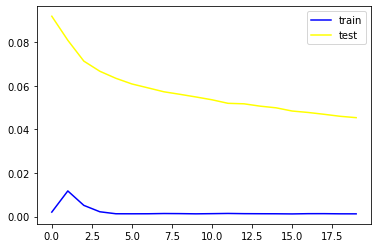

In [12]:
data_prepare = prepare_data(filepath,n_in, n_out)
scaler, data, train_X, train_y, test_X, test_y, dataset = data_prepare
model_list = fit_lstm(data_prepare, n_neuron, n_batch, n_epoch,repeats=repeats)

In [40]:
for i in range(len(model_list)):
    model = model_list[i]
    inv_yhat = lstm_predict(model, data_prepare)[0]
    inv_y = lstm_predict(model, data_prepare)[1]
    inv_yhat_list.append(inv_yhat)
    inv_y_list.append(inv_y)

(6342, 30)
(6342, 30)


In [14]:
inv_yhat_ave = np.zeros(inv_y.shape)
for i in range(repeats):
    inv_yhat_ave += inv_yhat_list[i]
    
inv_yhat_ave = inv_yhat_ave/repeats

In [15]:
rmse_dic_list = []
for i in range(len(model_list)):
    inv_yhat = inv_yhat_list[i]
    inv_y = inv_y_list[i]
    rmse_dic = evaluate_forecasts(inv_y, inv_yhat, n_out)
    rmse_dic_list.append(rmse_dic)

rmse_dic_list.append(evaluate_forecasts(inv_y, inv_yhat_ave, n_out))

df_dic = {}
for i in range(len(rmse_dic_list) - 1):
    df_dic['第' + str(i+1) + '次'] = pd.Series(rmse_dic_list[i])
    
df_dic['平均'] = pd.Series(rmse_dic_list[i+1])
rmse_df = DataFrame(df_dic)
rmse_df

第1次           平均
t+1 RMSE   1723.358541  1723.358541
t+2 RMSE   1706.855628  1706.855628
t+3 RMSE   1699.642463  1699.642463
t+4 RMSE   1678.878465  1678.878465
t+5 RMSE   1753.720179  1753.720179
t+6 RMSE   1685.724432  1685.724432
t+7 RMSE   1748.524089  1748.524089
t+8 RMSE   1715.748856  1715.748856
t+9 RMSE   1684.010112  1684.010112
t+10 RMSE  1712.019169  1712.019169
t+11 RMSE  1753.592466  1753.592466
t+12 RMSE  1778.878754  1778.878754
t+13 RMSE  1669.462228  1669.462228
t+14 RMSE  1786.970876  1786.970876
t+15 RMSE  1759.900801  1759.900801
t+16 RMSE  1760.122674  1760.122674
t+17 RMSE  1728.689202  1728.689202
t+18 RMSE  1698.625711  1698.625711
t+19 RMSE  1660.060579  1660.060579
t+20 RMSE  1633.920169  1633.920169
t+21 RMSE  1653.042541  1653.042541
t+22 RMSE  1796.194898  1796.194898
t+23 RMSE  1719.690862  1719.690862
t+24 RMSE  1733.384177  1733.384177
t+25 RMSE  1707.054305  1707.054305
t+26 RMSE  1729.776413  1729.776413
t+27 RMSE  1708.132811  1708.132811
t+28 RMSE  1712.833900  1712.833900
t+29 RMSE  1731.345427  1731.345427
t+30 RMSE  1737.360711  1737.360711

In [16]:
s = inv_yhat_ave[0].shape
erro_rate = np.zeros(s)
for i in range(len(inv_y)):
    erro_rate += inv_yhat_ave[i]/inv_y[i]-1

erro_rate_ave = erro_rate/len(inv_y)
err_df = DataFrame(pd.Series(erro_rate_ave))
err_df.columns = ['平均预测错误率']
err_df.index = ['超前%d步预测' % (i+1) for i in range(n_out)]
err_df

平均预测错误率
超前1步预测  -0.048499
超前2步预测  -0.047957
超前3步预测  -0.048173
超前4步预测  -0.046847
超前5步预测  -0.049708
超前6步预测  -0.047561
超前7步预测  -0.049469
超前8步预测  -0.047953
超前9步预测  -0.047202
超前10步预测 -0.048336
超前11步预测 -0.049397
超前12步预测 -0.050442
超前13步预测 -0.046781
超前14步预测 -0.051429
超前15步预测 -0.050047
超前16步预测 -0.050084
超前17步预测 -0.049181
超前18步预测 -0.047836
超前19步预测 -0.046493
超前20步预测 -0.045725
超前21步预测 -0.046611
超前22步预测 -0.051082
超前23步预测 -0.048794
超前24步预测 -0.049712
超前25步预测 -0.048204
超前26步预测 -0.049017
超前27步预测 -0.047755
超前28步预测 -0.048365
超前29步预测 -0.048893
超前30步预测 -0.049016

       submit_time    duration  cpu    memory  instances_num  disk
0                0  131.964467  0.5  0.008935            197     0
1                1   58.142857  0.5  0.007895             77     0
2                2  109.452675  0.5  0.008997            243     0
3                3   38.068966  0.5  0.016007             29     0
4                4   30.615385  0.5  0.013356             13     0
...            ...         ...  ...       ...            ...   ...
31751        31751    5.000000  0.5  0.004121              1     0
31752        31752   85.000000  0.5  0.016338              1     0
31753        31753    7.000000  0.5  0.008055              2     0
31754        31754   39.000000  0.5  0.005736              3     0
31755        31755    1.583333  0.5  0.004173           6818     0

[31756 rows x 6 columns]


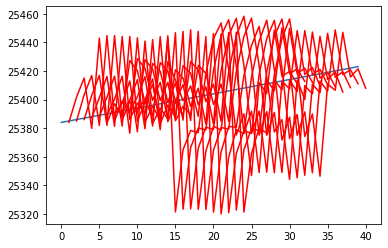

In [19]:
dataset = data_prepare[6]
test_X = data_prepare[4]
n_real = len(dataset)-len(test_X)-len(inv_yhat_ave[0])
#多画一个
print(dataset)
y_real = DataFrame(dataset['submit_time'][n_real:n_real+10+30])
plot_forecasts(y_real, inv_yhat_ave[0:10])

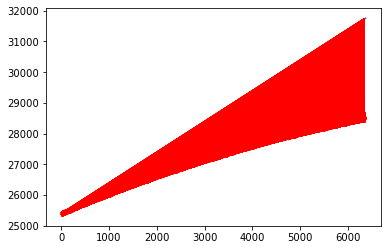

In [21]:
n_real = len(dataset)-len(test_X)-len(inv_yhat[0])
#多画一个
y_real = DataFrame(dataset['submit_time'][n_real:])
plot_forecasts(y_real, inv_yhat_ave)

In [24]:
pre_df = DataFrame(inv_yhat_ave)
print(pre_df)
pre_df = pre_df.round(decimals=2)#小数点

                0             1             2             3             4   \
0     25401.642578  25415.070312  25379.804688  25442.933594  25383.525391   
1     25403.248047  25416.845703  25381.878906  25444.685547  25385.187500   
2     25402.873047  25416.896484  25381.939453  25444.732422  25385.623047   
3     25401.291016  25416.154297  25381.246094  25444.091797  25385.990234   
4     25401.566406  25416.363281  25381.427734  25444.091797  25384.789062   
...            ...           ...           ...           ...           ...   
6337  28468.318359  28508.580078  28537.175781  28546.082031  28454.808594   
6338  28468.621094  28508.896484  28537.429688  28546.380859  28455.083984   
6339  28468.976562  28509.279297  28537.671875  28546.722656  28455.371094   
6340  28469.318359  28509.652344  28537.906250  28547.060547  28455.667969   
6341  28469.707031  28510.101562  28538.156250  28547.455078  28456.019531   

                5             6             7             8    

In [27]:
actual_df = DataFrame(inv_y)
names_columns = ['未来%d期' % (i+1) for i in range(n_out)]
actual_df.columns = names_columns
actual_df = actual_df.round(decimals=2)
print(actual_df)

         未来1期     未来2期     未来3期     未来4期     未来5期     未来6期     未来7期     未来8期  \
0     25385.0  25386.0  25387.0  25388.0  25389.0  25390.0  25391.0  25392.0   
1     25386.0  25387.0  25388.0  25389.0  25390.0  25391.0  25392.0  25393.0   
2     25387.0  25388.0  25389.0  25390.0  25391.0  25392.0  25393.0  25394.0   
3     25388.0  25389.0  25390.0  25391.0  25392.0  25393.0  25394.0  25395.0   
4     25389.0  25390.0  25391.0  25392.0  25393.0  25394.0  25395.0  25396.0   
...       ...      ...      ...      ...      ...      ...      ...      ...   
6337  31722.0  31723.0  31724.0  31725.0  31726.0  31727.0  31728.0  31729.0   
6338  31723.0  31724.0  31725.0  31726.0  31727.0  31728.0  31729.0  31730.0   
6339  31724.0  31725.0  31726.0  31727.0  31728.0  31729.0  31730.0  31731.0   
6340  31725.0  31726.0  31727.0  31728.0  31729.0  31730.0  31731.0  31732.0   
6341  31726.0  31727.0  31728.0  31729.0  31730.0  31731.0  31732.0  31733.0   

         未来9期    未来10期  ...    未来21期   